# Model Training 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sqlite3 as sql
import pickle

#### <font color = "blue"> _To run models immedietely_ </font>

In [96]:
def load_flat_gafs():
    """
    Loads flat gadf images (2D tensor) to train and test ML models
    - Input:  - 
    - Output: train_X, train_Y, test_X, test_Y
    """
    conn = sql.connect('FX_data/database.db')
    cur = conn.cursor()
    train_X = pd.read_sql_query("SELECT * FROM gadf_flat_train_X ",conn)
    train_Y = pd.read_sql_query("SELECT * FROM gadf_flat_train_Y ",conn)
    test_X = pd.read_sql_query("SELECT * FROM gadf_flat_test_X ",conn)
    test_Y = pd.read_sql_query("SELECT * FROM gadf_flat_test_Y ",conn)
    conn.close()
    return train_X, train_Y, test_X, test_Y

def summarise_results(labels,predictions,probabilities,dates):
    """
    DF to be used by trader 
    - Input model predictions, targets, dates  (must be an array of values 1d)
    - Output Shape: df, Date index, Target, Prediction, Correct
    """
    data= { #"Target":list(labels),
            "Target":list(labels),
            "Prediction":list(predictions)}
    df = pd.DataFrame.from_dict(data)
    df['Correct'] = 0 # zero when forecast in Incorrect 
    df['Correct'] = df['Correct'].where(df['Target'].values!=df['Prediction'].values, 1)
    df = pd.concat([df,probabilities],axis=1)
    df['Date'] = dates
    df.set_index(['Date'],inplace=True)
    #df.name = model_name
    return df

def binary_model_statistics(y_true, y_pred):
    """
    Calculates models performance statistics 
    - Inputs: labels, predictions 
    - Outputs: accuracy, precision, recall
    - prints results
    """
    accuracy = accuracy_score(y_true, y_pred.astype('int64'))
    precision = precision_score(y_true, y_pred.astype('int64'))
    recall = recall_score(y_true, y_pred.astype('int64'))
    print(' Data Accuracy (%) = ', round(accuracy*100,2))
    print(' Data Precision (%) = ', round(precision*100,2))
    print(' Data Recall (%) = ', round(recall*100,2))    
    return accuracy, precision, recall

#### Load Data

In [32]:
# Load GADF images 
train_X, train_Y, train_dates  ,   test_X, test_Y, test_dates = pd.read_pickle('FX_data/usd_eur_gadf.pkl')
[x.shape for x in [train_X, train_Y, train_dates, test_X, test_Y, test_dates]]

[(6127, 10, 10, 4), (6127,), (6127, 1), (1525, 10, 10, 4), (1525,), (1525, 1)]

# ML Classifiers
[Example 1. logistic R](https://www.kaggle.com/gulsahdemiryurek/image-classification-with-logistic-regression)
- useful for setting shape of image 
- uses numpy and cv package
- x_train.reshape(number_of_train,x_train.shape[1]*x_train.shape[2]) 
    - transforms (6127, 10, 40) -> (6127, 400)
- usually can use .flatten()

[Example 2. TF logR](https://www.tensorflow.org/tutorials/keras/classification)
- MLP simple tf.Keras

In [3]:
# instances / features / height / width 
#train_X[1,:,:,:] # Four 10*10 images for a single label 

#### Prep images for ML model

(6127, 10, 40) (1525, 10, 40)


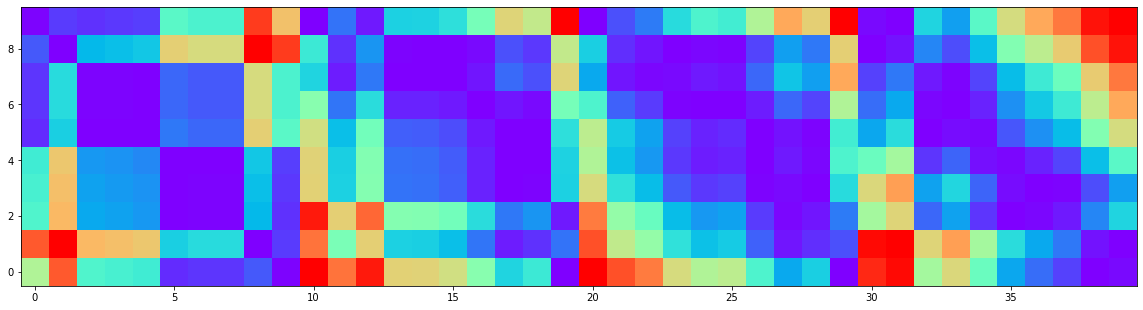

In [4]:
"""
Compress the ndarray into a single image by expanding horizontal axis 
- Input Shape (6127, 10, 10, 4)
- Output Shape: (6127, 10, 40)
- Preserves all data, but now have 6127 images of height*width 10*40
"""
def join_images(data):
    l = []
    for i in range(data.shape[-1]):
        l.append(data[:, :, :, i])
    return np.dstack( l )    

# Create conjointed images 
features_train = join_images(train_X)
features_test = join_images(test_X)

print(features_train.shape, features_test.shape)
# Example of the concatenated (4 features) GADF image 
fig = plt.figure(figsize=(20, 14))
im = plt.imshow(features_train[-1], cmap='rainbow', origin='lower')
plt.savefig("images/GADF_flat.png")

In [5]:
# Flatten images for simple ML classifiers 
"""
Simple ML classifiers cannot hadle more than 3 dimensions
- Input Shape (6127, 10, 40)
- Output Shape: (6127, 400)
- Preserves data by flattening pixels for each instance 
"""
def flatten_images(data):
    df = pd.DataFrame(data.reshape(data.shape[0],
                features_train.shape[1] * features_train.shape[2]))
    df.columns = [ "pixel_"+str(x) for x in range(0,400)]
    return df
    
train_flat = flatten_images(features_train)
test_flat = flatten_images(features_test)

print(train_flat.shape, test_flat.shape)

(6127, 400) (1525, 400)


#### Save GADF_flat to database

In [7]:
conn = sql.connect('FX_data/database.db')
cur = conn.cursor()
train_flat.to_sql("gadf_flat_train_X", conn, if_exists="replace",index=False)
pd.DataFrame(train_Y).to_sql("gadf_flat_train_Y", conn, if_exists="replace",index=False)
test_flat.to_sql("gadf_flat_test_X", conn, if_exists="replace",index=False)
pd.DataFrame(test_Y).to_sql("gadf_flat_test_Y", conn, if_exists="replace",index=False)
conn.close()

## M1 [Logistic Regression](https://towardsdatascience.com/building-a-logistic-regression-in-python-step-by-step-becd4d56c9c8)

In [35]:
from sklearn.linear_model import LogisticRegression

In [36]:
model_name = "LogisticRegression" # to save to databse
train_X, train_Y, test_X, test_Y = load_flat_gafs()
_, _, train_dates  ,   _, _, test_dates = pd.read_pickle('FX_data/usd_eur_gadf.pkl') # load dates 

logreg = LogisticRegression(solver="newton-cg") #'saga' did not  converge
model = logreg.fit(train_X, train_Y)

C:\Users\09ale\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [100]:
predictions = model.predict(test_X)
probabilities = pd.DataFrame(np.round(model.predict_proba(test_X)*100,2), columns =["% Buy","% Sell"])
df_LogR = summarise_results(test_Y['0'], predictions,probabilities,test_dates) # must be an array of values
binary_model_statistics(test_Y, predictions) # performance statistics 
df_LogR.head(3)

 Data Accuracy (%) =  49.97
 Data Precision (%) =  51.57
 Data Recall (%) =  52.03


,Target,Prediction,Correct,% Buy,% Sell
Date,,,,,
2004-03-01,0,1,0,37.25,62.75
2004-03-02,0,0,1,51.20,48.80
2004-03-03,0,1,0,22.13,77.87


In [104]:
conn = sql.connect('FX_data/database.db')
cur = conn.cursor()
df_LogR.to_sql(model_name, conn, if_exists="replace",index=True)
conn.close()

## Recursive Feature Elimination (RFE) 
<font color='red'>*TAKES A WHILE TO COMPUTE*</font>

Is based on the idea to repeatedly construct a model and choose either the best or worst performing feature, setting the feature aside and then repeating the process with the rest of the features. This process is applied until all features in the dataset are exhausted. The goal of RFE is to select features by recursively considering smaller and smaller sets of features.

- [Example for pixel-based evalutation](https://scikit-learn.org/stable/auto_examples/feature_selection/plot_rfe_digits.html#sphx-glr-auto-examples-feature-selection-plot-rfe-digits-py)


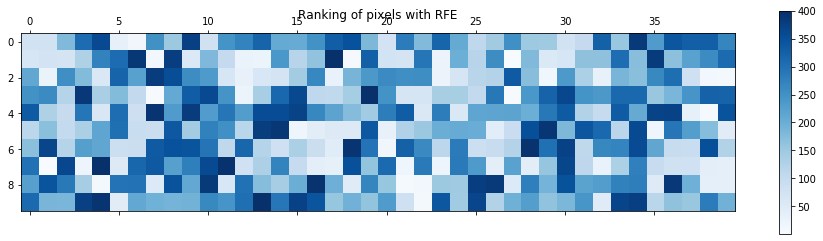

<Figure size 432x288 with 0 Axes>

In [105]:
" Uses Logistic Regression "
from sklearn.feature_selection import RFE
train_X, train_Y, test_X, test_Y = load_flat_gafs()

rfe = RFE(estimator=logreg, n_features_to_select=1, step=1)
rfe.fit(train_flat, train_Y)
ranking = rfe.ranking_.reshape((10,40))

# Plot pixel ranking
fig = plt.figure(figsize=(20, 14))
plt.matshow(ranking, cmap=plt.cm.Blues)
plt.colorbar()
plt.title("Ranking of pixels with RFE")
plt.savefig("RFE.png")
plt.show()
plt.savefig("images/RFE.png")

## M1 TensorFlow implimentation
- from book: Pramod_Singh,_Avinash_Manure: Learn_TensorFlow_2.
- pg 43.

In [4]:
# Load TF V1 
# import tensorflow.compat.v1 as tf
# tf.disable_v2_behavior()
import tensorflow as tf
print("TensorFlow method: ",tf.__version__)
      
from tensorflow import keras
from tensorflow.estimator import LinearClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score

# Load data
model_name = "LogisticRegression_TF" # to save to databse
train_X, train_Y, test_X, test_Y = load_flat_gafs()
_, _, train_dates  ,   _, _, test_dates = pd.read_pickle('FX_data/usd_eur_gadf.pkl') # load dates

TensorFlow method:  2.0.0


#### Build the input pipeline for the TensorFlow model.


In [44]:
def feed_input (features, labels, epochs=10, shuffle=False, batch_size=32 ):
    def input_feed_function():
        dataset = tf.data.Dataset.from_tensor_slices( (dict(features),labels) )
        if shuffle: dataset = dataset.shuffle(2000)
        dataset = dataset.batch(batch_size).repeat(epochs)
        return dataset
    return input_feed_function

train_feed_input = feed_input(train_X, train_Y)
train_feed_input_testing = feed_input(train_X,
                                      train_Y, 
                                      epochs=1, shuffle=False)

test_feed_input = feed_input(test_X, test_Y, epochs=1,shuffle=False)

#### Model (LogR) Training

In [45]:
feature_columns_numeric = [tf.feature_column.numeric_column(m) for m in train_X.columns]
logistic_model = LinearClassifier (feature_columns = feature_columns_numeric)
logistic_model.train(train_feed_input)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\09ale\\AppData\\Local\\Temp\\tmpu3n9vt_r', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000001903F015C08>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:C

#### Predictions

In [61]:
train_pred = logistic_model.predict(train_feed_input_testing)
test_pred = logistic_model.predict(test_feed_input)

# Create df with dates / predictions / targets / correct(0 or 1)
df_train_pred = summarise_results(pd.DataFrame([p['classes'][0].decode("utf-8") for p in train_pred]),train_Y,train_dates)
df_test_pred  = summarise_results(pd.DataFrame([p['classes'][0].decode("utf-8") for p in test_pred]), test_Y, test_dates)

In [62]:
# df_train_pred = pd.DataFrame(train_pred_series, columns=['predictions'])
# df_test_pred = pd.DataFrame(test_pred_series, columns=['predictions'])

#training_labels.reset_index(drop=True, inplace=True)
# df_train_pred.reset_index(drop=True, inplace=True)
# test_labels.reset_index(drop=True, inplace=True)
# test_predictions_df.reset_index(drop=True, inplace=True)
# train_results = pd.concat([train_Y, df_train_pred], axis=1)
# test_results = pd.concat([test_Y,df_test_pred], axis=1)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\09ale\AppData\Local\Temp\tmpu3n9vt_r\model.ckpt-1920
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


#### Validation

In [ ]:
# training data statistics 
binary_model_statistics(train_Y, train_pred)

In [ ]:
# test data statistics 
binary_model_statistics(test_Y, test_pred)

In [ ]:
################# FIX THE ABOVE USING THE BELOW TO GET RESULTS AND SAVE TO SQL ################

In [70]:
predictions = model.predict(test_X)
probabilities = pd.DataFrame(np.round(model.predict_proba(test_X)*100,2), columns =["% Buy","% Sell"])
df_LogR = summarise_results(test_Y['0'], predictions,probabilities,test_dates) # must be an array of values
binary_model_statistics(test_Y, predictions) # performance statistics 

In [ ]:
conn = sql.connect('FX_data/database.db')
cur = conn.cursor()
df_LogR.to_sql("logisticR", conn, if_exists="replace",index=True)
conn.close()


=====================================   END   ===============================================